Peer review Exercise: IBM Machine Learning Professional Certificate - Supervised Machine learning Regression
Author: KH

Dataset: 
New York stock exchange (NYSE) timeseries data on the stock price and the dividend pay-out.
Data extracted from Yahoo finance using ‘yfinance’ library (pipeline of extraction not shown).

Target & features:
In the previous module (exploratory data analysis) we took a sample of all NYSE exchange listed stocks. We took a sample from the 5 most mentioned sectors on the NYSE.
The sectors were as following: Basic Industries, Capital Goods, Consumer Services, Energy, Finance
Across all 5 sectors we focus on 221 individual listings. Were we took the delta price change over the last 5 years (which we will continue to use as a feature).

Additionally we are going to use financial summary data. From this data we will want to predict 1 element the 'forward P/E'. This is the expected or prognosed future stock price vs earning ratio. (basically we want to predict how the earnings and price of the stock will develop)

As other additional features we will use: averageVolume, beta(a volatility score), dividendRate, marketCap, payoutRatio, priceToSalesTrailing12Months
Apart from the numeric features, we transform the 5 sectors (categorical variable) into dummyvariables to use in the regression as well.
(We have 5 dummy vars and 6 numerical variables)

Data cleaning - prep: 
We cast all columns to their appropriate datatype, we will fill na's to 0 (non existent dividend data means no dividend is paid out). We will only train and predict on positive 'forward P/E' for simplicity.

Data preprocessing:
We will do 4 variations of linear regression
1. Standard 'vanilla' linear regression
2. Linear regression with polynomial features
3. Linear regression with standard scaling
4. Linear regression with standard scaling and regularization (LASSO)

Accordingly we tune the hyperparameters for the LASSO. Which results in an 0.35 (see notebook for detail)

Regression:
We perform our regression and check the sum of the coefficients for each regression and the number of coefficients (as LASSO will also perform feature selection)

lr - sum of coefficients: 32.44755594828273
lr - number of coefficients not equal to 0: 11
lr with pf - sum of coefficients: 7.873958800697449e-07
lr with pf - number of coefficients not equal to 0: 67
lr with ss - sum of coefficients: 19.853144486876573
lr with ss - number of coefficients not equal to 0: 11
LASSO - sum of coefficients: 16.22859423951995
LASSO - number of coefficients not equal to 0: 6

We see that LASSO reduced our number of features by 5. 

Let's have a look at the r2 values to see how well our model fits to the test data (Visualisations in the notebook below): 
linear reg - 0.32
linear reg with pf - -0.25
linear reg with ss- 0.35
linear reg with ss and LASSO - 0.3

Conclusions:
- standard scaling does improve the performance of the model
- Polynomial features should be regularized as model performance is poor on just the polynomial features
- Regularization improves interpretability (reduced features), and variance. Model performace slightly lower than normal regression


When we compare the scaled features regression coefficients with the LASSO. We find that LASSO eliminates: 'Marketcap', 'Beta', 'Payoutratio', 'Basic industries', 'Capital goods'. This does make sense, the marketcap (no. shares outstanding), beta (volatility) and payoutratio (how much dividend you pay) don't have a logical link with the forward P/E per se. Interestingly the 'Consumer services' dummy var is the highest positive predictor and Finance the most negative predictor (while basic industries and capital goods were eliminated). So there seems to be a sector dependent relationship with the forward P/E. Lastly as expected the delta stock price (price development over the last 5 years) has a strong positive relationship with the forward P/E. 
(See 'dfCoefBest' for de coefficients)

Flaws & plan of action:

- The polynomial features need to be regularized, model performance suffered heavily under the introduction of these.
- Explore the sector dependent predictors (the largest (both negative and positive) coefficients belong to sectors), are there features that underline the sectors (multicolinearity)?
- Sell my finance stock and go into consumer services! (Seems there's a better outlook / potential earnings!)

Thank you for reviewing my course material, cheers!


In [1]:
%%time
#Import libraries
import math
import pandas as pd
import numpy as np
import plotly.express as px
#import herepy
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 
import matplotlib.dates as mdates
from datetime import date
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
from datetime import datetime
import random

from scipy.stats.stats import pearsonr


# finance lib
import yfinance as yf

from yahooquery import Ticker

Wall time: 2.86 s


In [2]:
# Style
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

sns.set(style="darkgrid")

In [3]:
# Yahoo finance data

dfdelta = pd.read_csv('data/DeltaStockPrice2005to2020NYSE.csv') # preprocessed data from the EDA 

dfsum = pd.read_csv('data/NYSEsummary.csv') # financial NYSE data that will be the input for the model


In [4]:
# We take a preselected set of variables that we will use as features
fields = ['Unnamed: 0', 'averageVolume', 'beta', 'forwardPE', 'marketCap', 'dividendRate', 'payoutRatio', 'priceToSalesTrailing12Months']

dfsum = pd.read_csv('data/NYSEsummary.csv', usecols=fields, index_col=False).rename(columns={'Unnamed: 0': 'ticker'})


In [5]:
dfdelta

,ticker,sector,ClosePrice2005,ClosePrice2020,deltastockprice
0,AB,Finance,15.190,27.33,79.92
1,AEM,Basic Industries,11.695,61.49,425.78
2,AEO,Consumer Services,10.465,11.24,7.41
3,AFG,Finance,14.535,66.77,359.37
4,AIG,Finance,831.435,29.96,-96.40
...,...,...,...,...,...
216,WRB,Finance,12.600,61.36,386.98
217,WTM,Finance,588.025,895.62,52.31
218,WTS,Capital Goods,26.820,85.77,219.80
219,XOM,Energy,36.960,43.20,16.88


In [6]:
dfsum

,ticker,averageVolume,beta,dividendRate,forwardPE,marketCap,payoutRatio,priceToSalesTrailing12Months
0,A,1340287,1.068561,0.72,27.25068,30834085888,0.3171,5.90352
1,AA,5863845,2.295959,NaN,-168.85713,2265574656,0.0,0.23768093
2,AA,5863845,2.295959,NaN,-168.85713,2265574656,0.0,0.23768093
3,B,229325,1.137681,0.64,18.984375,1841818496,0.2807,1.40708
4,AAN,709264,1.700111,0.16,11.676891,3833728256,NaN,0.9353283
...,...,...,...,...,...,...,...,...
2864,H,857267,1.421404,NaN,-31.391813,5281467904,0.2348,3.047587
2865,ZEN,1756275,1.324414,NaN,147.77144,11939665920,0.0,12.914895
2866,ZNH,30940,1.752409,NaN,388.85712,11584178176,0.0,NaN
2867,ZTR,125528,1.152731,NaN,NaN,371340992,NaN,23.750624


In [7]:
# We merge our 5 year delta price with the financial data (where we fill nans in with 0's; As some of these companies do not pay out dividends)
dfdeltaAlldata = dfdelta.merge(dfsum, on='ticker').fillna(0)
                  
# We will transform the sector categorical variable into a dummy field and use it as input later
dfSectorDummies = pd.get_dummies(dfdeltaAlldata['sector'])
dfdeltaAlldata = dfdeltaAlldata.join(dfSectorDummies)

In [8]:
dfdeltaAlldata

,ticker,sector,ClosePrice2005,ClosePrice2020,deltastockprice,averageVolume,beta,dividendRate,forwardPE,marketCap,payoutRatio,priceToSalesTrailing12Months,Basic Industries,Capital Goods,Consumer Services,Energy,Finance
0,AB,Finance,15.190,27.33,79.92,310189,1.531215,2.44,9.108108,2597110528,0.9963,9.025705,0,0,0,0,1
1,AEM,Basic Industries,11.695,61.49,425.78,1409353,0.881828,0.8,21.80274,19179657216,0.3382,7.1965694,1,0,0,0,0
2,AEO,Consumer Services,10.465,11.24,7.41,7065901,1.277591,0.14,13.981818,2554833408,0,0.6694626,0,0,1,0,0
3,AFG,Finance,14.535,66.77,359.37,489490,0.872352,2.0,8.03341,6173901312,0.6917,0.8472487,0,0,0,0,1
4,AIG,Finance,831.435,29.96,-96.40,6718492,1.387402,1.28,6.5475636,24309665792,0,0.50027096,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,WRB,Finance,12.600,61.36,386.98,682271,0.807692,0.48,19.637821,10906305536,0.2486,1.4185357,0,0,0,0,1
488,WTM,Finance,588.025,895.62,52.31,13978,0.511148,1.0,43.903336,2451196928,0.033299997,4.614452,0,0,0,0,1
489,WTS,Capital Goods,26.820,85.77,219.80,194232,0.969899,0.92,26.097435,3427543296,0.2698,2.2604651,0,1,0,0,0
490,XOM,Energy,36.960,43.20,16.88,23773651,1.261984,3.48,22.435373,139447025664,2.0714,0.65205735,0,0,0,1,0


In [9]:
# Cast all relevant columns to floats
dfdeltaAlldata['averageVolume'] = dfdeltaAlldata['averageVolume'].astype(float)
dfdeltaAlldata['beta'] = dfdeltaAlldata['beta'].astype(float)
dfdeltaAlldata['dividendRate'] = dfdeltaAlldata['dividendRate'].astype(float)
dfdeltaAlldata['forwardPE'] = dfdeltaAlldata['forwardPE'].astype(float)
dfdeltaAlldata['marketCap'] = dfdeltaAlldata['marketCap'].astype(float)
dfdeltaAlldata['payoutRatio'] = dfdeltaAlldata['payoutRatio'].astype(float)
dfdeltaAlldata['priceToSalesTrailing12Months'] = dfdeltaAlldata['priceToSalesTrailing12Months'].astype(float)



In [10]:
dfdeltaAlldata.iloc[:,4:7].join(dfdeltaAlldata.iloc[:,9:17])

,deltastockprice,averageVolume,beta,marketCap,payoutRatio,priceToSalesTrailing12Months,Basic Industries,Capital Goods,Consumer Services,Energy,Finance
0,79.92,310189.0,1.531215,2.597111e+09,0.9963,9.025705,0,0,0,0,1
1,425.78,1409353.0,0.881828,1.917966e+10,0.3382,7.196569,1,0,0,0,0
2,7.41,7065901.0,1.277591,2.554833e+09,0.0000,0.669463,0,0,1,0,0
3,359.37,489490.0,0.872352,6.173901e+09,0.6917,0.847249,0,0,0,0,1
4,-96.40,6718492.0,1.387402,2.430967e+10,0.0000,0.500271,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
487,386.98,682271.0,0.807692,1.090631e+10,0.2486,1.418536,0,0,0,0,1
488,52.31,13978.0,0.511148,2.451197e+09,0.0333,4.614452,0,0,0,0,1
489,219.80,194232.0,0.969899,3.427543e+09,0.2698,2.260465,0,1,0,0,0
490,16.88,23773651.0,1.261984,1.394470e+11,2.0714,0.652057,0,0,0,1,0


In [11]:
dfdeltaAlldata = dfdeltaAlldata[dfdeltaAlldata['forwardPE'] > 0]

# Our predictor/Y is the Delta stockprice 
Target = "forwardPE"

#X = dfdeltaAlldata.iloc[:,5:] # We take the 7 numeric variables and the 5 dummy variables
x = dfdeltaAlldata.iloc[:,4:7].join(dfdeltaAlldata.iloc[:,9:17])


y = dfdeltaAlldata[Target]

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict

In [13]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(x)

In [14]:
# 1 - standard linear regression

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=72018)


# 2 - linear regression with polynomal features 
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(x)


X_train_pf, X_test_pf, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, 
                                                    random_state=72018)

# 3 - linear regression with standard scaling - using train sets from above
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.fit_transform(X_test)

# 4 - Linear regression with standard scaling and LASSO (regularization) - finding hyperparameter

alphas = np.geomspace(10, 100, num=10)
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, x, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    
print('The optimal hyperparameter setting for the lasso:', np.amax(scores))
    


The optimal hyperparameter setting for the lasso: 0.351079919837904


In [15]:
# 1 - standard linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
r2 = round(r2_score(y_test_pred, y_test), 2)

print('lr - sum of coefficients:', abs(lr.coef_).sum() )
print('lr - number of coefficients not equal to 0:', (lr.coef_!=0).sum())

# 2 - linear regression with polynomal features and standard scaling
lr_pf = LinearRegression()
lr_pf.fit(X_train_pf, y_train)
y_test_pred_pf = lr_pf.predict(X_test_pf)
r2_pf = round(r2_score(y_test_pred_pf, y_test), 2)

print('lr with pf - sum of coefficients:', abs(lr_pf.coef_).sum() )
print('lr with pf - number of coefficients not equal to 0:', (lr_pf.coef_!=0).sum())

# 3 - linear regression with standard scaling - using train sets from above
lr_s = LinearRegression()
lr_s.fit(X_train_s, y_train)
y_test_pred_s = lr_s.predict(X_test_s)
r2_s = round(r2_score(y_test_pred_s, y_test), 2)

print('lr with ss - sum of coefficients:', abs(lr_s.coef_).sum() )
print('lr with ss - number of coefficients not equal to 0:', (lr_s.coef_!=0).sum())

# 4 - Linear regression with standard scaling and LASSO (regularization) - finding hyperparameter
Las = Lasso(np.amax(scores), max_iter=100000)
Las.fit(X_train_s, y_train)
y_test_pred_Lasso = Las.predict(X_test_s)
r2_L = round(r2_score(y_test_pred_Lasso, y_test), 2)

print('LASSO - sum of coefficients:', abs(Las.coef_).sum() )
print('LASSO - number of coefficients not equal to 0:', (Las.coef_!=0).sum())



lr - sum of coefficients: 32.44755594828273
lr - number of coefficients not equal to 0: 11
lr with pf - sum of coefficients: 7.873958800697449e-07
lr with pf - number of coefficients not equal to 0: 67
lr with ss - sum of coefficients: 19.853144486876573
lr with ss - number of coefficients not equal to 0: 11
LASSO - sum of coefficients: 16.22859423951995
LASSO - number of coefficients not equal to 0: 6


In [16]:
# r2's
print('linear reg - ' + str(r2))
print('linear reg with pf - ' + str(r2_pf))
print('linear reg with ss- ' + str(r2_s))
print('linear reg with ss and LASSO - ' + str(r2_L))

linear reg - 0.32
linear reg with pf - -0.25
linear reg with ss- 0.35
linear reg with ss and LASSO - 0.3


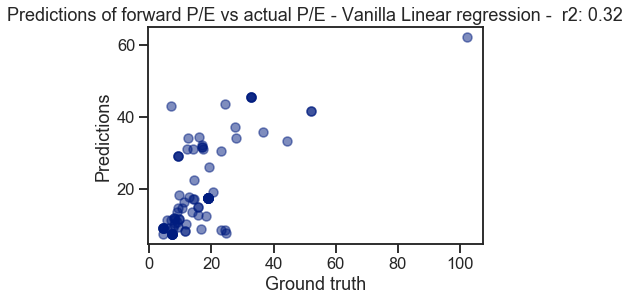

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Predictions of forward P/E vs actual P/E - Vanilla Linear regression -  r2: ' + str(r2));

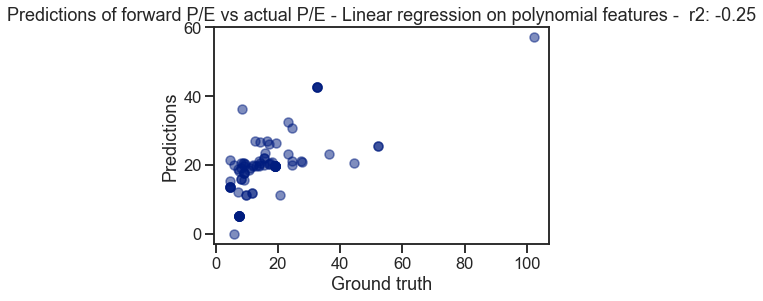

In [24]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred_pf, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Predictions of forward P/E vs actual P/E - Linear regression on polynomial features -  r2: ' + str(r2_pf));

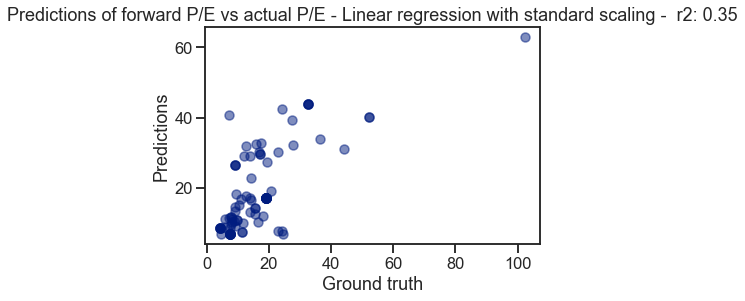

In [25]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred_s, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Predictions of forward P/E vs actual P/E - Linear regression with standard scaling -  r2: ' + str(r2_s));

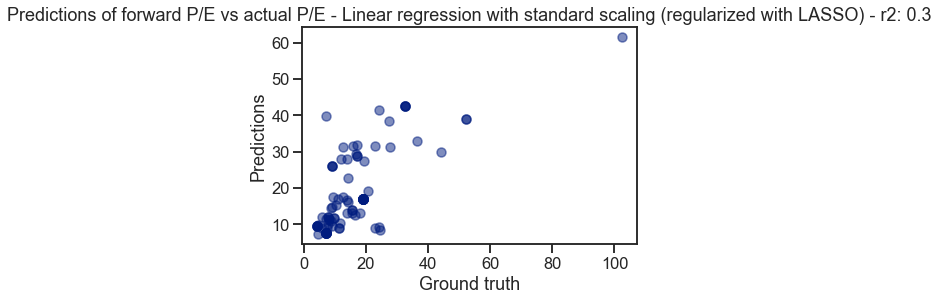

In [26]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred_Lasso, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Predictions of forward P/E vs actual P/E - Linear regression with standard scaling (regularized with LASSO) - r2: ' + str(r2_L));

In [27]:
# Let's have a look at the coefficients of our regressions (polynomial excluded due to feature 'expansion')
dfCoef = pd.DataFrame()
dfCoef['Feature'] = x.columns
dfCoef['Vanilla linear regression (lr)'] = lr.coef_
dfCoef['lr with standard scaled features'] = lr_s.coef_
dfCoef['lrn with standard scaled features (LASSO)'] = Las.coef_

dfCoef

,Feature,Vanilla linear regression (lr),lr with standard scaled features,lrn with standard scaled features (LASSO)
0,deltastockprice,1.747509e-02,5.115182,5.087442
1,averageVolume,-2.601880e-08,-0.422963,-0.148997
2,beta,-1.483941e-01,-0.072807,-0.000000
3,marketCap,1.382994e-13,0.006388,-0.000000
4,payoutRatio,-1.176185e-01,-0.361999,-0.000000
5,priceToSalesTrailing12Months,5.276807e-01,1.860889,1.828927
6,Basic Industries,-1.685192e+00,-0.402490,0.000000
7,Capital Goods,-2.027242e+00,-0.799784,0.000000
8,Consumer Services,1.581819e+01,6.182303,6.656994
9,Energy,-5.834305e+00,-1.921506,-0.894865


In [28]:
dfCoefBest = dfCoef.drop(columns=['Vanilla linear regression (lr)']).sort_values(by=['lr with standard scaled features'], ascending=False)
dfCoefBest

,Feature,lr with standard scaled features,lrn with standard scaled features (LASSO)
8,Consumer Services,6.182303,6.656994
0,deltastockprice,5.115182,5.087442
5,priceToSalesTrailing12Months,1.860889,1.828927
3,marketCap,0.006388,-0.000000
2,beta,-0.072807,-0.000000
4,payoutRatio,-0.361999,-0.000000
6,Basic Industries,-0.402490,0.000000
1,averageVolume,-0.422963,-0.148997
7,Capital Goods,-0.799784,0.000000
9,Energy,-1.921506,-0.894865
